In [1]:
import torch
import torch.nn as nn
from networks import SCLIPNN
import clip
from PIL import Image
from sentence_transformers import SentenceTransformer

We can now test what happens if you use a multilingual SBERT model and put in a Spanish sentence and map it to CLIP and then compare it against a image put into CLIP. Maybe you can first just test some examples using arbitrary example images. I.e. try a Spanish sentence with different images (some that match the sentence well, some that match it less well, some that don't match it at all).

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
spanish_sentences = ["un perro blanco", "un animal grande", "la muchacha de pelo azul", "un avion azules"]
sbert_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

In [16]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)
text = clip.tokenize(spanish_sentences).to(device)

In [17]:
im = Image.open("imgs/poodle.jpg")
width, height = im.size
new_width = int(width / 4)
new_height = int(height / 4)
image = preprocess(im).unsqueeze(0).to(device)

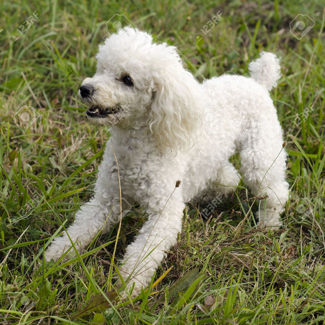

In [18]:
im = im.resize((new_width, new_height))
im.show()

In [19]:
import numpy as np
def get_logits(image_features, text_features):
    # normalized features
    if text_features.dtype == torch.int64:
        text_features = text_features.type(torch.FloatTensor)
    image_features = (image_features / image_features.norm(dim=-1, keepdim=True)).to(device)
    text_features = (text_features / text_features.norm(dim=-1, keepdim=True)).to(device)

    # cosine similarity as logits
    logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
    logit_scale = logit_scale.exp().to(device)
    logits_per_image = logit_scale * image_features @ text_features.t()
    logits_per_text = logits_per_image.t()

    # shape = [global_batch_size, global_batch_size]
    return logits_per_image, logits_per_text    

In [20]:
def sbert_to_clip(sbert_features):
    input_size = sbert_features.shape[1]
    PATH = "models/best_model.pt"
    model = SCLIPNN(input_size,850)
    model.load_state_dict(torch.load(PATH))
    model.eval()
    output = model(sbert_features)
    return output

In [21]:
with torch.no_grad():
    image_features = clip_model.encode_image(image)
    sbert_features = torch.from_numpy(sbert_model.encode(spanish_sentences))
    sbert_features = sbert_to_clip(sbert_features).type(torch.float16)
    clip_features = clip_model.encode_text(text)
    logits_image_clip, logits_text_clip = get_logits(image_features, clip_features)
    logits_image_sbert, logits_text_sbert = get_logits(image_features, sbert_features)
    probs_clip = logits_image_clip.softmax(dim=-1).cpu().numpy()
    probs_sbert = logits_image_sbert.softmax(dim=-1).cpu().numpy()


print("CLIP Label probs:", probs_clip[0]) 
print("SBERT Label probs:", probs_sbert[0]) # prints: [[0.9927937  0.00421068 0.00299572]]

CLIP Label probs: [0.4233 0.2484 0.2188 0.1094]
SBERT Label probs: [0.506  0.2145 0.1731 0.1068]
